# Keras integration

TODO: Some explanation...

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import gpflux
from gpflow.ci_utils import reduce_in_tests

import matplotlib.pyplot as plt

2023-05-31 07:12:49.534783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline

In [3]:
d = np.load("../../tests/snelson1d.npz")
X, Y = d["X"], d["Y"]
num_data, input_dim = X.shape
_, output_dim = Y.shape

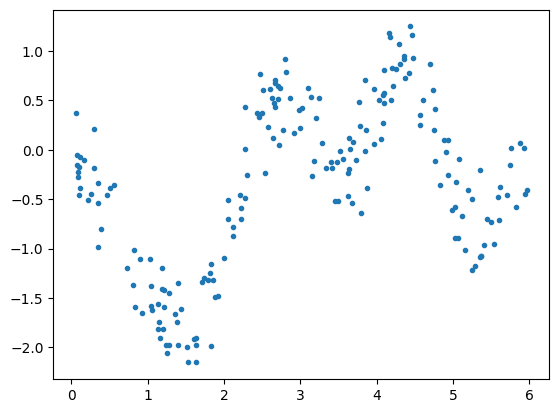

In [4]:
plt.figure()
plt.plot(X, Y, ".")
plt.show()

In [5]:
def create_layers():
    num_inducing = 13
    hidden_dim = 1
    Z = np.linspace(X.min() - 0.1, X.max() + 0.1, num_inducing).reshape(-1, 1)

    layer1 = gpflux.helpers.construct_gp_layer(
        num_data, num_inducing, input_dim, hidden_dim, z_init=Z.copy()
    )
    layer1.mean_function = gpflow.mean_functions.Identity()  # TODO: pass layer_type instead
    layer1.q_sqrt.assign(layer1.q_sqrt * 0.01)

    layer2 = gpflux.helpers.construct_gp_layer(
        num_data, num_inducing, hidden_dim, output_dim, z_init=Z.copy()
    )

    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))

    return layer1, layer2, likelihood_layer

In [6]:
def create_model(model_class):
    """
    We pass in `model_class` to make it easy to use
    `gpflux.optimization.NatGradModel`, which is required for combining
    GPflow's `NaturalGradient` optimizer with Keras. `model_class` needs to be
    a constructor that has the same semantics as `tf.keras.Model.__init__`.
    """
    layer1, layer2, likelihood_layer = create_layers()
    dgp = gpflux.models.DeepGP([layer1, layer2], likelihood_layer, default_model_class=model_class)
    return dgp

In [7]:
batch_size = 2
num_epochs = reduce_in_tests(200)

In [8]:
dgp = create_model(tf.keras.Model)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        patience=5,
        factor=0.95,
        verbose=1,
        min_lr=1e-6,
    )
]

dgp_train = dgp.as_training_model()
dgp_train.compile(tf.optimizers.Adam(learning_rate=0.1))

history = dgp_train.fit(
    {"inputs": X, "targets": Y}, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks
)

/tmp/ipykernel_3860/2200924875.py:16: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Epoch 1/2


  1/100 [..............................] - ETA: 6:39 - loss: 75.4133 - gp_layer_prior_kl: 0.2668 - gp_layer_1_prior_kl: 0.0000e+00

 31/100 [========>.....................] - ETA: 0s - loss: 15.8724 - gp_layer_prior_kl: 0.0582 - gp_layer_1_prior_kl: 0.0673      

 61/100 [=================>............] - ETA: 0s - loss: 9.7274 - gp_layer_prior_kl: 0.0616 - gp_layer_1_prior_kl: 0.0883 

 91/100 [==========================>...] - ETA: 0s - loss: 7.0929 - gp_layer_prior_kl: 0.0550 - gp_layer_1_prior_kl: 0.0912

100/100 [==============================] - 4s 2ms/step - loss: 6.6871 - gp_layer_prior_kl: 0.0528 - gp_layer_1_prior_kl: 0.0915 - lr: 0.1000


Epoch 2/2


  1/100 [..............................] - ETA: 0s - loss: 1.5756 - gp_layer_prior_kl: 0.0326 - gp_layer_1_prior_kl: 0.0997

 31/100 [========>.....................] - ETA: 0s - loss: 1.3919 - gp_layer_prior_kl: 0.0355 - gp_layer_1_prior_kl: 0.1072

 60/100 [=================>............] - ETA: 0s - loss: 1.2405 - gp_layer_prior_kl: 0.0333 - gp_layer_1_prior_kl: 0.0990

 88/100 [=========================>....] - ETA: 0s - loss: 1.1813 - gp_layer_prior_kl: 0.0317 - gp_layer_1_prior_kl: 0.0948

100/100 [==============================] - 0s 2ms/step - loss: 1.1654 - gp_layer_prior_kl: 0.0309 - gp_layer_1_prior_kl: 0.0929 - lr: 0.1000


In [9]:
dgp_natgrad = create_model(gpflux.optimization.NatGradModel)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        patience=5,
        factor=0.95,
        verbose=1,
        min_lr=1e-6,
    )
]

dgp_natgrad_train = dgp_natgrad.as_training_model()
dgp_natgrad_train.natgrad_layers = (
    True  # we want all (here two) GPLayer instances trained by NaturalGradient
)
# alternatively, we could set `natgrad_layers` explicitly to the GPLayer instances inside the model
dgp_natgrad_train.compile(
    [
        gpflow.optimizers.NaturalGradient(gamma=0.05),
        gpflow.optimizers.NaturalGradient(gamma=0.05),
        tf.optimizers.Adam(learning_rate=0.1),
    ]
)

history_natgrad = dgp_natgrad_train.fit(
    {"inputs": X, "targets": Y}, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks
)

/tmp/ipykernel_3860/2200924875.py:16: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))


Epoch 1/2


Executing NatGradModel backwards pass


Executing NatGradModel backwards pass


  1/100 [..............................] - ETA: 6:07 - loss: 163.2631 - gp_layer_2_prior_kl: 0.2668 - gp_layer_3_prior_kl: 0.0000e+00

 29/100 [=======>......................] - ETA: 0s - loss: 17.2560 - gp_layer_2_prior_kl: 0.2668 - gp_layer_3_prior_kl: 0.0216       

 58/100 [================>.............] - ETA: 0s - loss: 10.5003 - gp_layer_2_prior_kl: 0.2667 - gp_layer_3_prior_kl: 0.0272

 87/100 [=========================>....] - ETA: 0s - loss: 7.7186 - gp_layer_2_prior_kl: 0.2666 - gp_layer_3_prior_kl: 0.0307 

100/100 [==============================] - 4s 2ms/step - loss: 6.9568 - gp_layer_2_prior_kl: 0.2665 - gp_layer_3_prior_kl: 0.0320 - lr: 0.1000


Epoch 2/2


  1/100 [..............................] - ETA: 0s - loss: 3.2345 - gp_layer_2_prior_kl: 0.2661 - gp_layer_3_prior_kl: 0.0415

 25/100 [======>.......................] - ETA: 0s - loss: 1.1927 - gp_layer_2_prior_kl: 0.2660 - gp_layer_3_prior_kl: 0.0428

 50/100 [==============>...............] - ETA: 0s - loss: 1.2879 - gp_layer_2_prior_kl: 0.2659 - gp_layer_3_prior_kl: 0.0438

 77/100 [======================>.......] - ETA: 0s - loss: 1.2394 - gp_layer_2_prior_kl: 0.2658 - gp_layer_3_prior_kl: 0.0451

100/100 [==============================] - 0s 2ms/step - loss: 1.1725 - gp_layer_2_prior_kl: 0.2657 - gp_layer_3_prior_kl: 0.0461 - lr: 0.1000


In [10]:
dgp_test = dgp.as_prediction_model()
res = dgp_test(X)

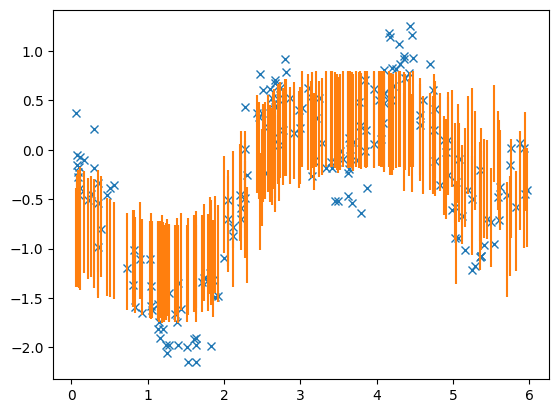

In [11]:
plt.plot(X, Y, "x")
plt.errorbar(X.squeeze(), np.squeeze(res.y_mean), np.sqrt(np.squeeze(res.y_var)), ls="")
plt.show()

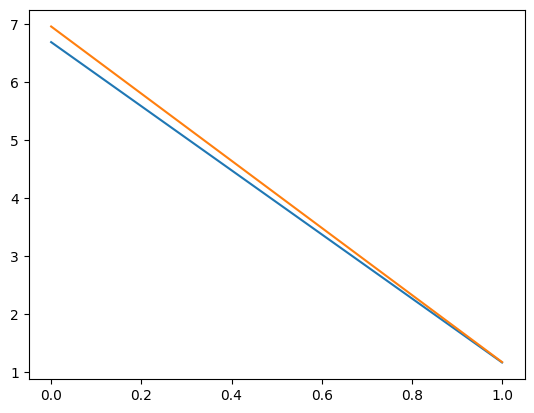

In [12]:
plt.plot(history.history["loss"], label="Adam")
plt.plot(history_natgrad.history["loss"], label="NatGrad")
plt.show()